# Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# Importing required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE

import featuretools as ft
import gc

%matplotlib inline
sns.set(style='whitegrid', palette='inferno', font_scale=1.5)

import warnings
warnings.filterwarnings(action="ignore")

Using TensorFlow backend.


In [2]:
# load the data
data = pd.read_csv("../input/creditcard.csv")

# Exploratory Data Analysis

In [3]:
# get column names
colNames = data.columns.values
colNames

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [4]:
# get dataframe dimensions
print ("Dimension of dataset:", data.shape)

Dimension of dataset: (284807, 31)


In [5]:
# get attribute summaries
print(data.describe())

                Time            V1      ...               Amount          Class
count  284807.000000  2.848070e+05      ...        284807.000000  284807.000000
mean    94813.859575  3.919560e-15      ...            88.349619       0.001727
std     47488.145955  1.958696e+00      ...           250.120109       0.041527
min         0.000000 -5.640751e+01      ...             0.000000       0.000000
25%     54201.500000 -9.203734e-01      ...             5.600000       0.000000
50%     84692.000000  1.810880e-02      ...            22.000000       0.000000
75%    139320.500000  1.315642e+00      ...            77.165000       0.000000
max    172792.000000  2.454930e+00      ...         25691.160000       1.000000

[8 rows x 31 columns]


In [6]:
# get class distribution
print ("Normal transaction:", data['Class'][data['Class']==0].count()) #class = 0
print ("Fraudulent transaction:", data['Class'][data['Class']==1].count()) #class = 1

Normal transaction: 284315
Fraudulent transaction: 492


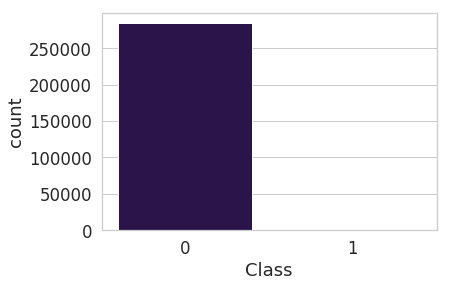

In [7]:
sns.countplot(data['Class'])

In [8]:
# separate classes into different datasets
normal_class = data.query('Class == 0')
fraudulent_class = data.query('Class == 1')

# randomize the datasets
normal_class = normal_class.sample(frac=1,random_state=1210)
fraudulent_class = fraudulent_class.sample(frac=1,random_state=1210)

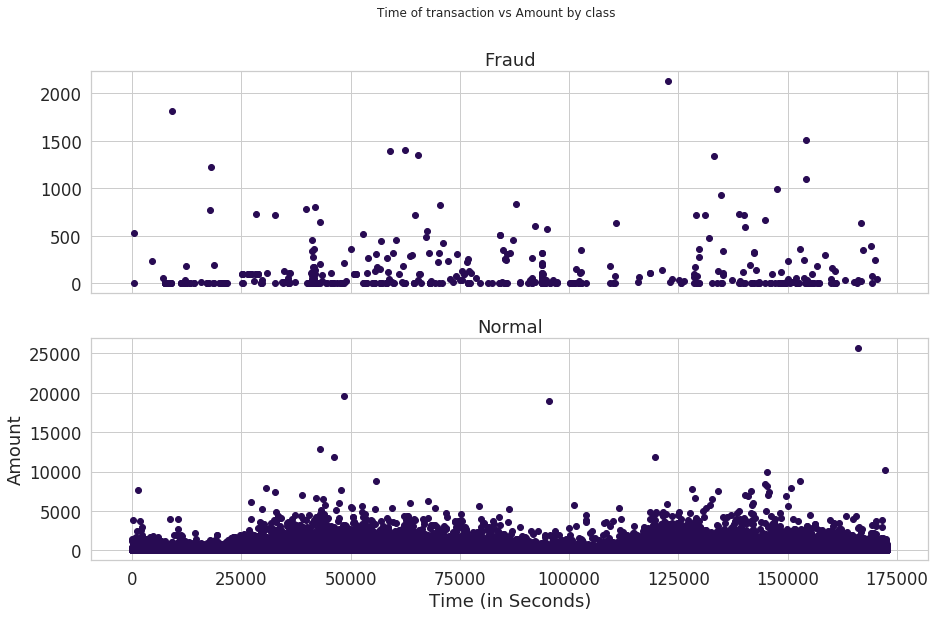

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudulent_class.Time, fraudulent_class.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal_class.Time, normal_class.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### The above graph shows that **Time** is irrelevent for detecting fraudulent transactions

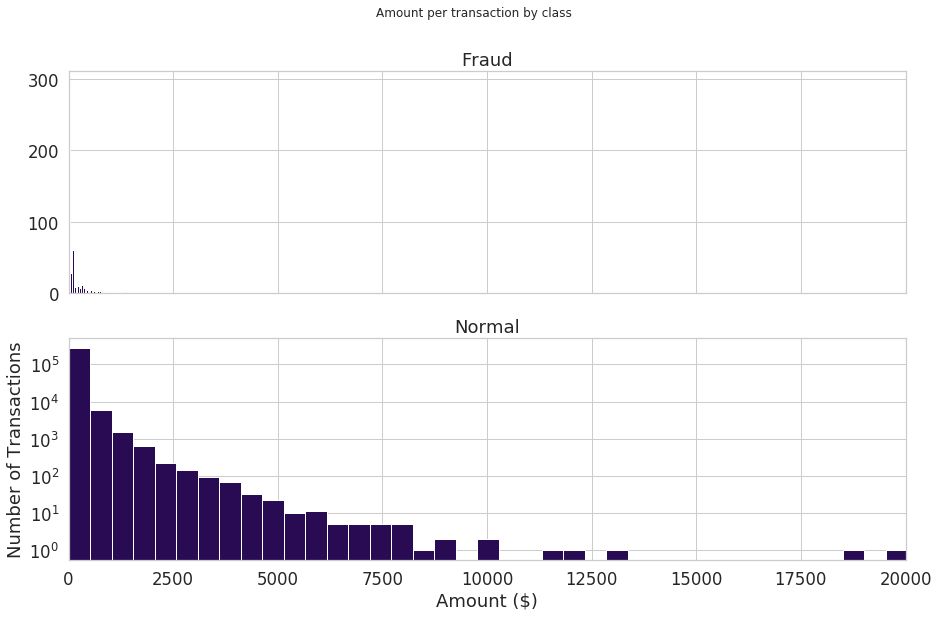

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudulent_class.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal_class.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### The above graph shows that most of the fraudulent transactions are of very low amount

In [11]:
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [12]:
# separate classes into different datasets
normal_class = data.query('Class == 0')
fraudulent_class = data.query('Class == 1')

# randomize the datasets
normal_class = normal_class.sample(frac=1,random_state=1210)
fraudulent_class = fraudulent_class.sample(frac=1,random_state=1210)

# Oversampling to deal with class imbalance

The examples of the majority class, in this case the normal transactions, drastically outnumber the 
incidences of fraudulent transactions in our dataset. One of the strategies employed in the data science community is 
to generate synthetic data points for under-represented class to improve the learning function.

In [13]:
X = data.drop(['Class'], axis = 1)

y = data['Class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1210)

In [15]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
173987,2.127226,-1.643078,-1.159414,-1.518021,-1.149425,-0.442776,-0.984404,-0.202669,-1.215514,1.518490,-1.089482,-0.773160,0.618763,-0.461747,-0.121729,-0.614277,0.496413,-0.047300,-0.233034,-0.217525,-0.024487,0.247002,0.116678,0.609697,-0.113286,-0.099451,-0.006217,-0.030100,0.080563
77761,1.177903,-0.929866,0.319984,-0.498674,-1.066237,-0.232614,-0.642941,0.128873,-0.569807,0.648112,1.234257,-0.325851,-1.635079,0.142826,-0.857036,0.393276,0.910494,-1.575976,0.780217,0.048374,0.166972,0.367693,-0.100628,0.229286,0.481693,-0.147744,-0.003171,0.004886,-0.055652
91298,1.221186,-0.295558,0.410340,-0.284122,-0.590148,-0.096934,-0.554816,0.273252,0.505344,-0.018864,1.004780,-0.343666,-2.234629,0.795863,1.081323,0.514318,-0.323228,0.018659,0.099382,-0.226447,-0.103690,-0.395806,0.102709,-0.309064,-0.019430,0.944878,-0.073410,-0.012666,-0.349631
221298,2.048182,0.638386,-2.351720,0.774162,0.583337,-1.801964,0.422012,-0.450297,0.406073,-1.218897,0.319023,0.128246,0.647175,-2.667034,0.996125,0.737166,1.734709,1.185247,-0.706290,-0.111200,0.105753,0.541638,-0.054482,-0.149789,0.279473,-0.105431,0.024512,0.009372,-0.349231
24116,1.253101,-0.328803,0.724816,0.754850,-0.758306,0.096501,-0.513748,0.000848,-0.668544,0.611323,-0.695491,0.800967,1.174151,-0.479524,-0.445411,-2.221561,0.469785,0.373917,-1.164202,-0.527725,-0.402208,-0.362199,-0.004080,0.087413,0.552820,-0.271258,0.088693,0.027293,-0.313249


In [16]:
gc.collect()

8295

In [17]:
def score(model, test = X_test, y_true = y_test):
    
    pred = model.predict(test)

    print('Average precision-recall score RF:\t', round(average_precision_score(y_true, pred),4)*100)
    print()
    print("Cohen's Kappa Score:\t",round(cohen_kappa_score(y_true,pred),4)*100)
    print()
    print("R-Squared Score:\t",round(r2_score(y_true,pred),4)*100)
    print()
    print("Area Under ROC Curve:\t",round(roc_auc_score(y_true,pred),4)*100)
    print()
    print(classification_report(y_true,pred))
    
    
    precision, recall, _ = precision_recall_curve(y_true, pred)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(y_true, pred)))
    
    
    
    fpr_rf, tpr_rf, _ = roc_curve(y_true, pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.step(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    #plt.fill_between(fpr_rf, tpr_rf, step='post', alpha=0.2, color='b')


    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    

In [18]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    plt.figure(figsize=(12, 9), dpi=80)
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

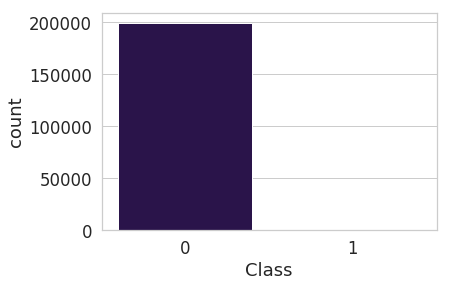

In [19]:
#np.unique(y_train, return_counts= True)
sns.countplot(y_train)

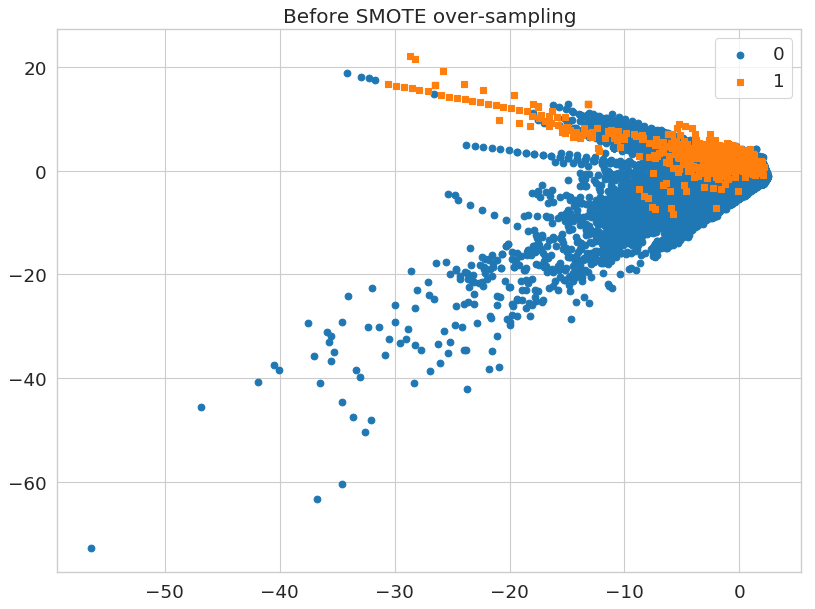

In [20]:
plot_2d_space(np.array(X), np.array(y), 'Before SMOTE over-sampling')

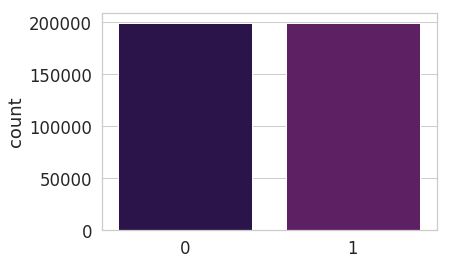

In [21]:
smote = SMOTE(ratio='minority', random_state=1210)
X_sm, y_sm = smote.fit_sample(X_train, y_train)

#np.unique(y_sm, return_counts= True)
sns.countplot(y_sm)

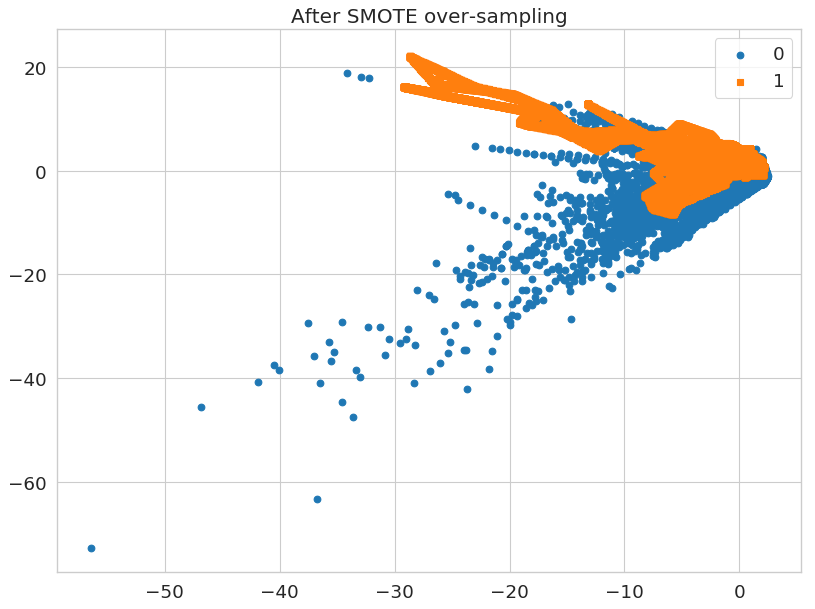

In [22]:
plot_2d_space(X_sm, y_sm, 'After SMOTE over-sampling')

# Time to train and test the performance of various models

{0: 85319, 1: 124}


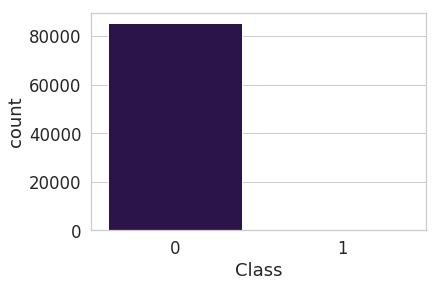

In [23]:
# See category counts for test data
category, records = np.unique(y_test, return_counts= True)
cat_counts = dict(zip(category,records))

print(cat_counts)
sns.countplot(y_test)

### Random Forest Classifier

In [24]:
rf_model = RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=8)

In [25]:
rf_model.fit(X_sm,y_sm)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   53.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.3min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 11.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.3s finished


Average precision-recall score RF:	 70.95

Cohen's Kappa Score:	 84.14

R-Squared Score:	 69.31

Area Under ROC Curve:	 90.72

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85319
           1       0.87      0.81      0.84       124

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.94      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443



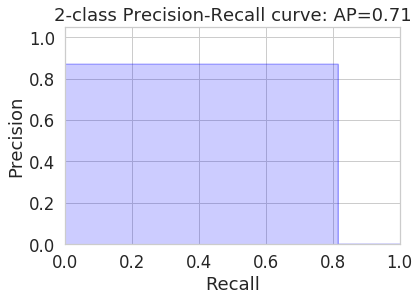

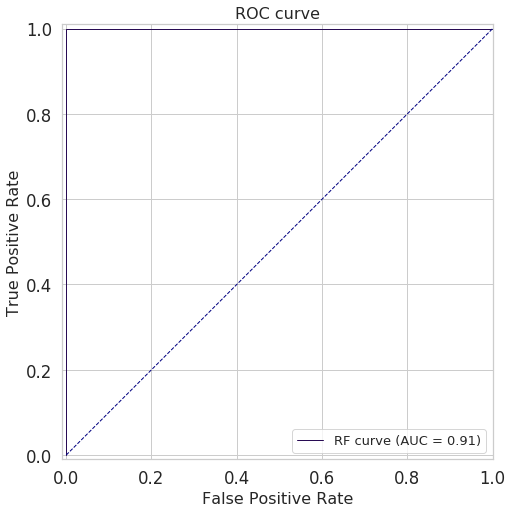

In [26]:
score(rf_model)

### XGBoost Classifier

In [27]:
xgb_model = XGBClassifier(n_estimators=500, n_jobs=8)

xgb_model.fit(X_sm,y_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Average precision-recall score RF:	 35.449999999999996

Cohen's Kappa Score:	 55.910000000000004

R-Squared Score:	 -33.26

Area Under ROC Curve:	 92.25

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85319
           1       0.42      0.85      0.56       124

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.71      0.92      0.78     85443
weighted avg       1.00      1.00      1.00     85443



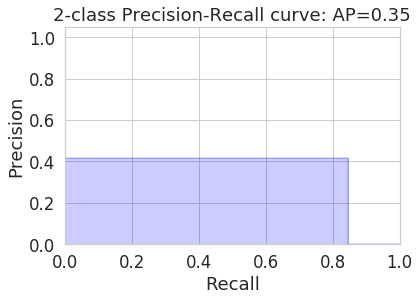

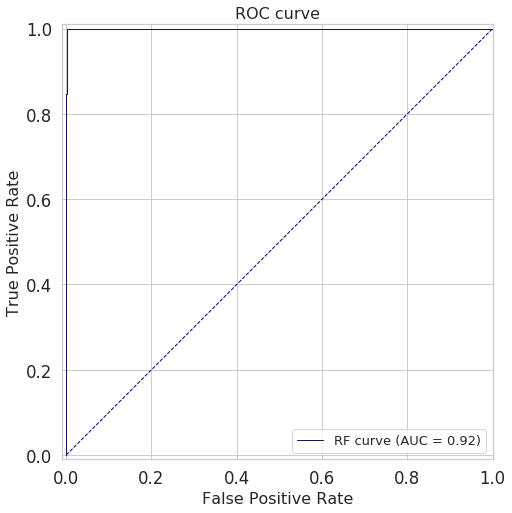

In [28]:
score(xgb_model, test= np.array(X_test))

### Logistic Regression

In [29]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_sm,y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Average precision-recall score RF:	 4.6

Cohen's Kappa Score:	 9.59

R-Squared Score:	 -1513.63

Area Under ROC Curve:	 92.78999999999999

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85319
           1       0.05      0.88      0.10       124

   micro avg       0.98      0.98      0.98     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.98      0.99     85443



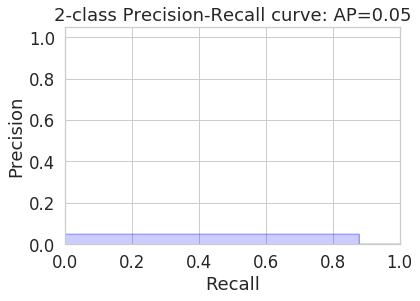

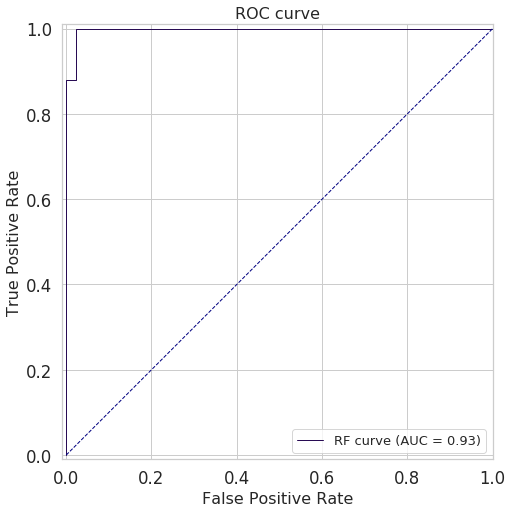

In [30]:
score(lr_model)

## Light GBM

In [31]:
import lightgbm

In [32]:
lgbm = lightgbm.LGBMClassifier(n_estimators=1000, verbose=1)

In [33]:
lgbm.fit(X_sm, y_sm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=1)

Average precision-recall score RF:	 18.27

Cohen's Kappa Score:	 34.98

R-Squared Score:	 -201.24

Area Under ROC Curve:	 90.52

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85319
           1       0.22      0.81      0.35       124

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.61      0.91      0.67     85443
weighted avg       1.00      1.00      1.00     85443



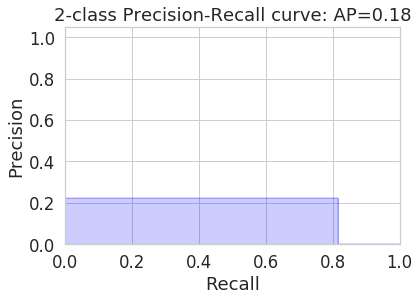

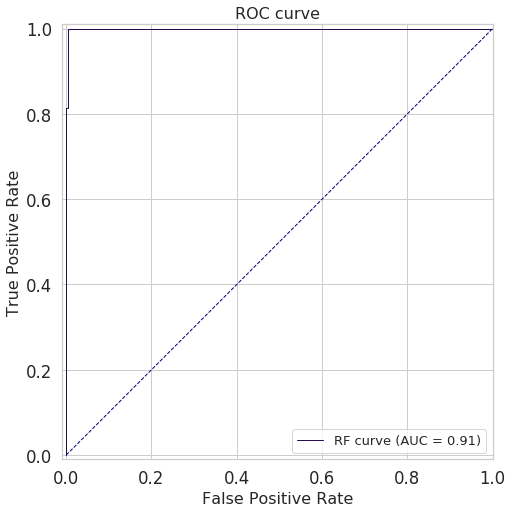

In [34]:
score(lgbm)

We can see that SMOTE doesn't give us very good results no matter which algorithm we try.
I believe this is because we don't have enough **actual** fraudulent samples and the patterns just get lost in between so many non-fraudulent transaction samples.

# Time to try Random Under-Sampling

In [35]:
normal_class.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
50830,-2.451616,1.973770,0.902784,1.595978,-1.805211,0.841257,-1.597407,2.246228,0.095427,-0.619581,0.023575,1.577278,-0.949392,0.687255,-2.102985,-1.034067,1.684673,-0.416375,1.473683,-0.268606,-0.147537,-0.462306,0.152206,0.207392,-0.017109,-0.409981,-0.230704,-0.022505,-0.337277,0
179064,0.421688,0.945353,-1.211215,1.097346,0.487790,-0.288520,0.788650,-0.491782,-0.042116,0.951397,-0.874999,-0.098403,0.117022,0.271491,0.788467,-1.625884,0.744338,-0.443474,2.697643,-0.017791,0.158948,0.567811,0.099097,0.692510,-1.123741,0.720585,-0.552023,0.071479,-0.196944,0
10158,-0.611302,0.557936,2.105733,-0.156311,0.185058,1.391241,-0.391631,0.338555,-0.403984,0.289462,1.170956,-1.965212,3.458752,1.129221,0.224462,-1.125524,0.101106,2.392241,-0.237865,-0.100114,-0.469743,-0.485072,-0.284958,-1.432350,0.216687,-0.242283,0.370493,0.130170,-0.290859,0


In [36]:
fraudulent_class.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
81186,-4.384221,3.264665,-3.077158,3.403594,-1.938075,-1.221081,-3.310317,-1.111975,-1.977593,-3.288204,2.886091,-6.848978,-1.029235,-7.460103,0.055906,-4.334783,-9.874560,-3.541903,-0.531559,-0.141533,2.076383,-0.990303,-0.330358,0.158378,0.006351,-0.493860,-1.537652,-0.994022,-0.170757,1
226877,-6.423306,1.658515,-5.866440,2.052064,-0.615817,-3.372266,-5.036556,2.643106,-2.274630,-7.049229,3.916803,-4.481280,-1.027479,-7.113873,-0.852775,-3.839560,-5.056010,-1.344498,1.148473,-0.713516,0.641211,-0.256678,-2.337233,-0.158278,1.198797,-0.261258,0.780125,-0.731801,-0.353229,1
42009,-2.740483,3.658095,-4.110636,5.340242,-2.666775,-0.092782,-4.388699,-0.280133,-2.821895,-4.466284,3.969800,-7.346717,-1.163312,-8.225569,0.825002,-6.772867,-8.815785,-4.568859,1.126599,0.185325,2.417495,-0.097712,0.382155,-0.154757,-0.403956,0.277895,0.830062,0.218690,0.095876,1


In [37]:
resampled = normal_class.sample(n=int(len(fraudulent_class)*3), random_state=1210)

In [38]:
len(resampled)

1476

In [39]:
data = pd.concat([fraudulent_class,resampled])

In [40]:
X_tr, X_te, y_tr, y_te = train_test_split(data.drop('Class',axis=1), data['Class'], test_size=0.2, random_state=1210)

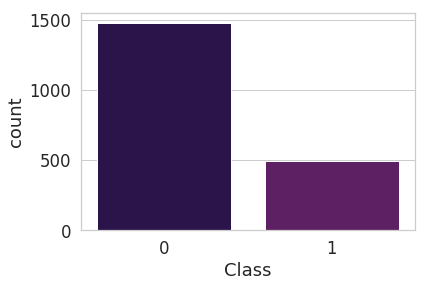

In [41]:
sns.countplot(data['Class'])

Average precision-recall score RF:	 93.01

Cohen's Kappa Score:	 93.31

R-Squared Score:	 87.02

Area Under ROC Curve:	 95.24000000000001

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       289
           1       1.00      0.90      0.95       105

   micro avg       0.97      0.97      0.97       394
   macro avg       0.98      0.95      0.97       394
weighted avg       0.98      0.97      0.97       394



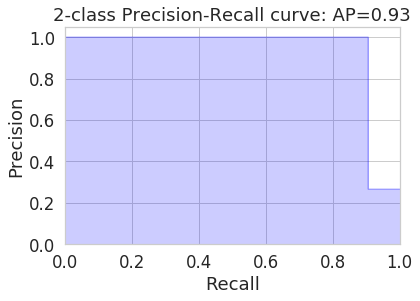

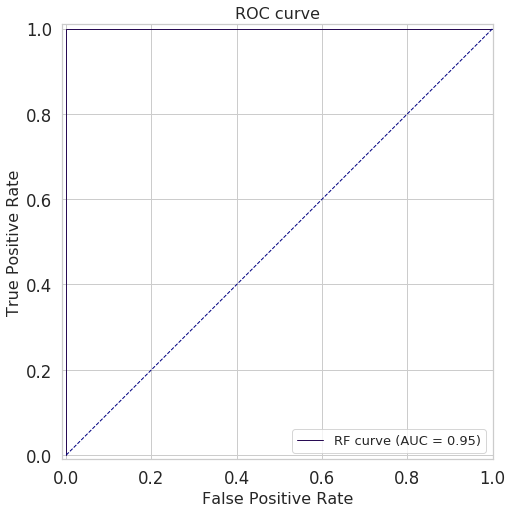

In [42]:
score(RandomForestClassifier(n_estimators=500,random_state=1210).fit(X_tr,y_tr),test=X_te, y_true=y_te)

Average precision-recall score RF:	 92.55

Cohen's Kappa Score:	 93.39

R-Squared Score:	 87.02

Area Under ROC Curve:	 95.84

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       289
           1       0.98      0.92      0.95       105

   micro avg       0.97      0.97      0.97       394
   macro avg       0.98      0.96      0.97       394
weighted avg       0.97      0.97      0.97       394



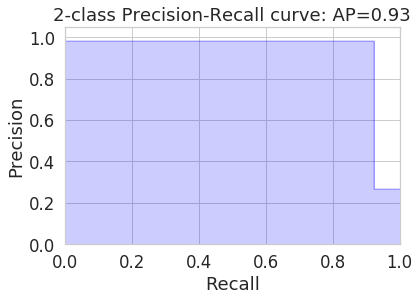

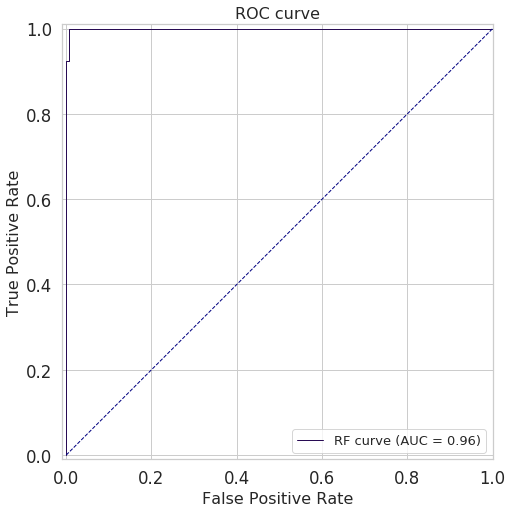

In [43]:
score(lightgbm.LGBMClassifier(n_estimators=5000, random_state=1210).fit(X_tr,y_tr),test=X_te, y_true=y_te)

# Results

### The best results are 92% Recall, 97% Precision with Area Under Precision-Recall Curve = 91.64%